Images and metadata: https://drive.google.com/file/d/1h91HNUN5UBE6CexoxI_eXIb-KSDZk85m/view?usp=sharing

In [2]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from IPython.display import Audio
sound_file = 'https://www.soundjay.com/button/beep-07.wav'
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import Input
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix, classification_report,roc_curve,auc
import itertools
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,GlobalAveragePooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
import keras
from keras.applications import InceptionV3,MobileNet
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from keras.optimizers import Adam
%matplotlib inline

Using TensorFlow backend.


### Loading and Pre-Processing Data

In [3]:
# set our input dimensions - can be changed later
input_dims = (100,100)

#set directory of images
PATHDATA = r'C:\Users\Admin\Downloads\skin-cancer-mnist-ham100002'

This function will set up a some dictionaries and add the info to the metadata csv accompanying the images. Details in comments below:

In [4]:
def create_df(path,input_dims):
    
    imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(PATHDATA, '*.jpg'))}

    # Create a dctionary of labels used for mapping later - 1 for melanoma, 0 for everything else
    
    lesion_class_dict = {
        'nv': '0',
        'mel': '1',
        'bkl': '0',
        'bcc': '0',
        'akiec': '0',
        'vasc': '0',
        'df': '0'
    }
    
    # create a another dictionary for mapping of dataset names and corresponding full names from HAM1000 paper
    
    lesion_name_dict = {
        'nv': 'Melanocytic nevi',
        'mel': 'Melanoma',
        'bkl': 'Benign keratosis-like lesions ',
        'bcc': 'Basal cell carcinoma',
        'akiec': 'Actinic keratoses',
        'vasc': 'Vascular lesions',
        'df': 'Dermatofibroma'
    }
    
    # Read in the metadata csv HAM10000
    
    df = pd.read_csv(os.path.join(path, 'HAM10000_metadata.csv'))
    
    
    # Create some new columns in the metadata using the dictionaries above: path to image on disk, class of lesion, and lesion name)
    
    df['path'] = df['image_id'].map(imageid_path_dict.get)
    df['class'] = df['dx'].map(lesion_class_dict.get) 
    df['lesion_name'] = df['dx'].map(lesion_name_dict.get)
    

    # loading image arrays into newly created 'image' column

    df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))
    
    return df

Now that the function is set up we can load and map all data including images to the metadata CSV:

In [21]:
df = create_df(PATHDATA,input_dims)

Check how the dataframe looks

In [6]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,class,lesion_name,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\Admin\Downloads\skin-cancer-mnist-ham...,0,Benign keratosis-like lesions,"[[[191, 154, 195], [193, 156, 197], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\Admin\Downloads\skin-cancer-mnist-ham...,0,Benign keratosis-like lesions,"[[[23, 11, 21], [25, 15, 26], [26, 15, 29], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\Admin\Downloads\skin-cancer-mnist-ham...,0,Benign keratosis-like lesions,"[[[187, 127, 137], [191, 137, 153], [193, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\Admin\Downloads\skin-cancer-mnist-ham...,0,Benign keratosis-like lesions,"[[[22, 11, 19], [27, 14, 24], [36, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\Admin\Downloads\skin-cancer-mnist-ham...,0,Benign keratosis-like lesions,"[[[134, 90, 113], [150, 102, 126], [158, 114, ..."


Next step is to create a train test split function which also one hot encodes the labels. 

In [7]:
def train_test(df):
    
    # stratify the split so classes have equal proportions 
    x_train, x_test, y_train, y_test = train_test_split(df['image'], df['class'], test_size=0.3,stratify=df['class'])


    #what's the training set split like? IMBALANCED
    
    print('Training set balance:\n',y_train.value_counts())
    print('Test set balance:\n',y_test.value_counts())
    
    
    x_train = np.asarray(x_train.tolist())
    x_test = np.asarray(x_test.tolist())
    
    
    # one hot encode the labels
    
    y_train = to_categorical(y_train,num_classes=2)
    y_test = to_categorical(y_test,num_classes=2)
    
    return x_train, x_test, y_train, y_test

Now set up three types of normalizing functions to test - zscore, maxmin and dividing by total number of pixels

In [8]:
def norm_z(xtrain,xtest):
    
    # standardizes image arrays by subtracting mean and dividing by std dev
    x = (xtrain - xtrain.mean())/xtrain.std()
    y = (xtest - xtrain.mean())/xtrain.std()
    
    return x,y

def norm_maxmin(xtrain,xtest):
    x = (xtrain-np.min(xtrain))/(np.max(xtrain)-np.min(xtrain))
    y = (xtest-np.min(xtrain))/(np.max(xtrain)-np.min(xtrain))

    return x,y
    
def norm_255(xtrain,xtest):
    x = xtrain/255
    y = xtest/255
    
    return x,y   

### Model Creation Function

In [9]:
def createModel(input_shape,num_classes):

    # inspired by Alexnet
    model = Sequential()
    
    # 1
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    # 2
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    # 3
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    
    # 4
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    
    # 5
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
      
    # 6
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    
    # 7
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(num_classes, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    
    return model
  

### Model Evaluation Function

Two functions to evaluate the model once trained: Single confusion matrix function and more indepth model evaluation function

Confusion Matrix Function:

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Evaluation function which calls the confusion matrix function:

In [11]:
def get_stats(model,history,x_test,y_test):
    
    # compuiting test loss and accuracy

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    class_names = ['Melanoma','Non Melanoma']
    
    # getting the predicted values
    
    y_pred_ohe = model.predict(x_test) 
    
    # converting predctions back to binary from one hot encoding
    
    y_pred_labels = np.argmax(y_pred_ohe, axis=1)
    
    # also converting test labels back to binary
    
    y_test_labels = np.argmax(y_test, axis=1)
    
    # can't get a classification report due to error 'Weights sum to zero, can't be normalized'. Need to sort this out
    print(classification_report(y_test_labels, y_pred_labels,target_names=['Non Melanoma','Melanoma'],digits=2))
    
    
    # assigning the confusion matrix to cm for sending to confusion visualization function
    
    cm=confusion_matrix(y_test_labels, y_pred_labels,labels=[1,0])
    
    # calling the confusion matrix function from earlier to display a plot
    
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cm,class_names,
                          title='Confusion matrix')
    plt.show()
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # plot ROC curve
    
        
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_labels, y_pred_labels)
    auc_keras = auc(fpr_keras, tpr_keras)
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='AUC (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('CNN ROC curve')
    plt.legend(loc='best')
    plt.show()

### Model Training

We now have our dataframe 'df' which has all the images in the ['image'] column, and all necessary functiions set up.  The cell below will initialize some parameters, create the train test split, normalize it, create the model, train it then evaluate it.

#### Base Model - zscore normalization

Loss begins around the 20th epoch. Very volatile training curves - set up a learning rate schedule perhaps. Low recall out of the box - next is image augmentation.

In [48]:
batch_size = 128
epochs = 50
num_classes = 2
input_shape = input_dims + (3,)
xtrain, xtest, ytrain, ytest = train_test(df)

# dataframe no longer needed
#del df

#create model
model1 = createModel(input_shape,num_classes)
    
#choose the type of normalization using the functions. Could also choose not to normalize it at all.
# norm_z(xtrain,xtest)
# norm_maxmin(xtrain,xtest)
# norm_255(xtrain,xtest)

xtrain,xtest = norm_z(xtrain,xtest)



# increase class weights of melanoma (class 1) as this is a highly imbalanced class
#class_weights=np.array([ 4.38673342,0.56432137])
class_weights={0: 1, 1: 4}    
# train model
history1 = model1.fit(xtrain, ytrain,
    batch_size=batch_size,
    class_weight=class_weights,
    epochs=epochs,
    verbose=1,
    validation_data=(xtest, ytest))

Audio(sound_file, autoplay=True)

Training set balance:
 0    6231
1     779
Name: class, dtype: int64
Test set balance:
 0    2671
1     334
Name: class, dtype: int64
Train on 7010 samples, validate on 3005 samples
Epoch 1/50
7010/7010 [==============================] - 13s 2ms/step - loss: 0.7805 - acc: 0.7534 - val_loss: 0.3075 - val_acc: 0.8438
Epoch 2/50
7010/7010 [==============================] - 10s 1ms/step - loss: 0.6475 - acc: 0.7800 - val_loss: 0.4168 - val_acc: 0.7418
Epoch 3/50
7010/7010 [==============================] - 10s 1ms/step - loss: 0.5999 - acc: 0.7904 - val_loss: 0.3653 - val_acc: 0.7850
Epoch 4/50
7010/7010 [==============================] - 10s 1ms/step - loss: 0.5772 - acc: 0.8096 - val_loss: 0.3285 - val_acc: 0.8228
Epoch 5/50
7010/7010 [==============================] - 10s 1ms/step - loss: 0.5622 - acc: 0.8178 - val_loss: 0.4164 - val_acc: 0.7532
Epoch 6/50
7010/7010 [==============================] - 10s 1ms/step - loss: 0.5383 - acc: 0.8325 - val_loss: 0.4880 - val_acc: 0.7526
Epoch 7/

Test loss: 0.6891798226754746
Test accuracy: 0.8868552415224161
              precision    recall  f1-score   support

Non Melanoma       0.92      0.96      0.94      2671
    Melanoma       0.49      0.34      0.40       334

 avg / total       0.87      0.89      0.88      3005

Confusion matrix


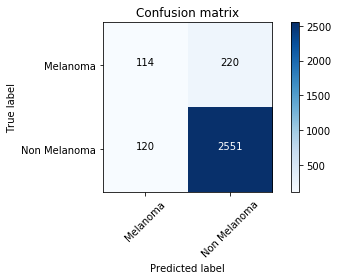

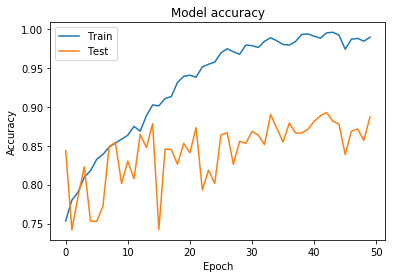

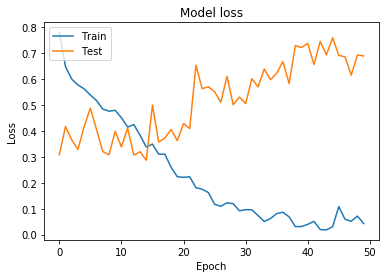

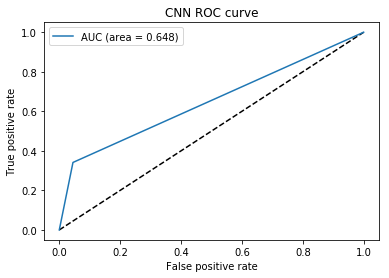

In [49]:
# evaluate
get_stats(model1,history1,xtest,ytest)

#### Now with image augmentation

None of these augmentations will affect the shape or appearance of the lesion - they are simple transformations such as zoom and shift left/right. Recall has now increased to .91 - ie 91% of melanoma lesions are being classified correctly. This metric is very important for a cancer classifier therefore I've been focusing on this the most. However there is a very large amount of false positives. Need to establish an acceptable level. Perhaps the adjusted class weight for melanoma is too high.

In [50]:
# same batch size and epochs

model2 = createModel(input_shape,num_classes)

datagen = ImageDataGenerator(
    zoom_range=0.3,          # randomly zoom into images
    rotation_range=90,      # randomly rotate images in the range (degrees, 0 to 180). 
    width_shift_range=0.2,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images
    vertical_flip=True)      # randomly flip images

# Fit the model on the batches generated by datagen.flow().
history2 = model2.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch_size),
                                steps_per_epoch=int(np.ceil(xtrain.shape[0] / float(batch_size))),
                                epochs=60,
                                class_weight={0: 1.0, 1: 4},
                                validation_data=(xtest, ytest),
                                workers=4)

Epoch 1/60
55/55 [==============================] - 13s 227ms/step - loss: 0.7686 - acc: 0.7609 - val_loss: 0.7633 - val_acc: 0.5308
Epoch 2/60
55/55 [==============================] - 9s 155ms/step - loss: 0.6771 - acc: 0.7894 - val_loss: 0.5477 - val_acc: 0.6007
Epoch 3/60
55/55 [==============================] - 9s 156ms/step - loss: 0.6493 - acc: 0.7895 - val_loss: 0.4364 - val_acc: 0.7295
Epoch 4/60
55/55 [==============================] - 9s 155ms/step - loss: 0.6321 - acc: 0.7989 - val_loss: 0.5231 - val_acc: 0.6707
Epoch 5/60
55/55 [==============================] - 9s 156ms/step - loss: 0.6297 - acc: 0.7987 - val_loss: 0.4558 - val_acc: 0.7125
Epoch 6/60
55/55 [==============================] - 12s 210ms/step - loss: 0.6108 - acc: 0.7974 - val_loss: 0.5679 - val_acc: 0.6346
Epoch 7/60
55/55 [==============================] - 15s 264ms/step - loss: 0.6147 - acc: 0.7889 - val_loss: 0.4627 - val_acc: 0.7145
Epoch 8/60
55/55 [==============================] - 9s 160ms/step - loss:

Test loss: 0.5645694526975444
Test accuracy: 0.6911813642935031
              precision    recall  f1-score   support

Non Melanoma       0.98      0.66      0.79      2671
    Melanoma       0.25      0.91      0.39       334

 avg / total       0.90      0.69      0.75      3005

Confusion matrix


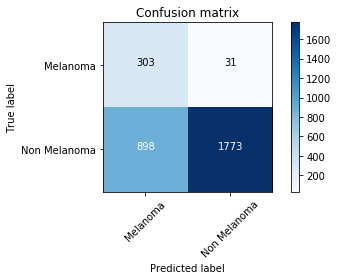

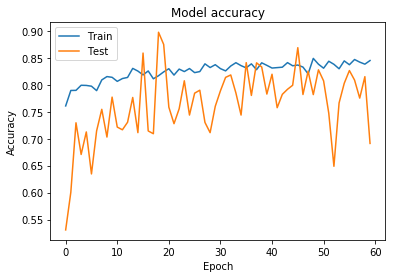

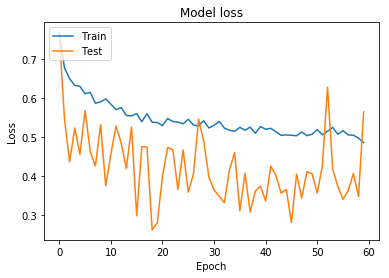

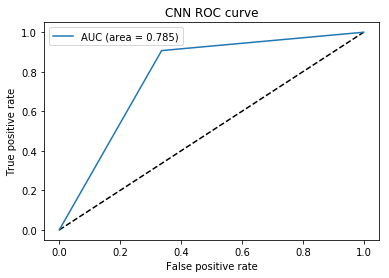

In [51]:
# evaluate
get_stats(model2,history2,xtest,ytest)

#### Other areas to investigate:

 - Another method of adjusting weights: Focal loss, which reduces the weights of well classified examples. This focuses the training on data that is harder to classify. https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758
 
 - Learning rate annealer / decay
 
 - Add more dropout to model - reduce overfitting
 
 - Transfer learning - VGGNet
 
 - Autocropping images - see autocrop code in repository
 
 - I have sourced 1,000 extra melanoma images. Will need to develop a method of splicing them into the above dataset. 
 